In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("./data/train_conv.csv") #del
df = df.sample(frac=1,random_state=100)

In [2]:
data = df.iloc[:,1:].values.astype('float')
labels = df.iloc[:,0].values.astype('float').reshape((-1,1))

In [3]:
del df

In [4]:
import keras
vali_rate = 0.01
end_index = np.floor(len(data) * (1-vali_rate)).astype('int')

data_x = data[:end_index].reshape((-1,48,48,1))/1.
data_y = keras.utils.to_categorical(labels[:end_index],num_classes=7)
validation_x = data[end_index:].reshape((-1,48,48,1))/1.
validation_y = keras.utils.to_categorical(labels[end_index:],num_classes=7)

Using TensorFlow backend.


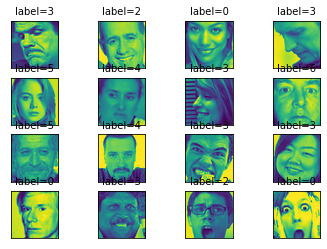

In [6]:
import utils
utils.plot_image_labels(validation_x,data_y)

In [7]:
import keras
from keras.layers import Dense,Conv2D,MaxPool2D,AveragePooling2D,Dropout,Flatten,BatchNormalization
import keras.layers.advanced_activations
from keras.layers import Activation
from keras import Sequential
from calls import SaveCall

model = Sequential([BatchNormalization(axis=-1,name='bn_1',input_shape=(48,48,1)),
                    Conv2D(32,(3,3),padding='valid',name='conv_1'),
                    BatchNormalization(axis=-1,name='bn_2'),
                    Activation(activation='tanh',name='tanh_1'),
                    
                    Conv2D(64,(3,3),padding='same',name='conv_2'),
                    BatchNormalization(axis=-1,name='bn_3'),
                    Activation(activation='tanh',name='tanh_2'),
                    MaxPool2D(pool_size=(3,3),name='maxpool_1'),
                    
                    Conv2D(128,(3,3),padding='same',name='conv_3'),
                    #beacause the advanced_activations prelu has no attributes __name__
                    #so, when save model it will error
                    #so, do not use Activation(PReLU())
                    keras.layers.advanced_activations.PReLU(name='prelu_1'),
                    AveragePooling2D(pool_size=(3,3),name='averagepooling_1'),
                    
                    Dropout(0.2,name='drop_1'),
                    Flatten(name='flatten_1'),
                    
                    Dense(256,name='dense_1'),
                    keras.layers.advanced_activations.PReLU(name='prelu_2'),
                    Dense(128,name='dense_2'),
                    keras.layers.advanced_activations.PReLU(name='prelu_3'),
                    Dense(7,name='dense_3'),
                    Activation(activation='softmax',name='softmax_1')
                    ]
                   ,name='sentiment_classification')

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])
imageGen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                                        featurewise_std_normalization=False,
                                                        horizontal_flip=True,
                                                        rotation_range=35
                                                        )
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn_1 (BatchNormalization)    (None, 48, 48, 1)         4         
_________________________________________________________________
conv_1 (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 46, 46, 32)        128       
_________________________________________________________________
tanh_1 (Activation)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 46, 46, 64)        18496     
_________________________________________________________________
bn_3 (BatchNormalizat

In [8]:
from typing import Optional
from calls import ConsoleCall
save_call = SaveCall("./h5/weights.{epoch}-{batch}-{loss:.5f}.h5",period=200,mode='train_mode')
iepoch = save_call.load(model)
batch_size = 32
epoch = 90
early_call = keras.callbacks.EarlyStopping(monitor='val_acc',patience=8,verbose=2,mode='max',restore_best_weights=True)
console_call = ConsoleCall(period=50)
history = model.fit_generator(imageGen.flow(data_x,data_y,batch_size),steps_per_epoch=len(data_x)/batch_size,
                    epochs=epoch,verbose=2,callbacks=[save_call,console_call,early_call],
                    #pay attention,the standardize function will change the args itself
                    validation_data=(validation_x,validation_y),
                    use_multiprocessing=False,initial_epoch=iepoch)
model.save('./h5/early_best.h5')

load weight from file ./h5/weights.87-509-0.98356.h5,start with epoch 87
last logs : {'batch': 509, 'size': 32, 'loss': 0.9835628, 'acc': 0.5625}
Instructions for updating:
Use tf.cast instead.
Epoch 88/90
{'batch': 48, 'size': 32, 'loss': 0.6275998, 'acc': 0.84375}
{'batch': 98, 'size': 32, 'loss': 0.61497533, 'acc': 0.75}
{'batch': 148, 'size': 32, 'loss': 0.5493318, 'acc': 0.78125}
{'batch': 198, 'size': 32, 'loss': 0.7739972, 'acc': 0.71875}
./h5/weights.87-199-0.54858.h5 has saved
{'batch': 248, 'size': 32, 'loss': 0.8084068, 'acc': 0.6875}
{'batch': 298, 'size': 32, 'loss': 0.6241261, 'acc': 0.84375}
{'batch': 348, 'size': 32, 'loss': 0.48423344, 'acc': 0.84375}
{'batch': 398, 'size': 32, 'loss': 0.8209563, 'acc': 0.6875}
./h5/weights.87-399-0.59640.h5 has saved
{'batch': 448, 'size': 32, 'loss': 0.5350471, 'acc': 0.75}
{'batch': 498, 'size': 32, 'loss': 0.9235078, 'acc': 0.75}
{'batch': 548, 'size': 32, 'loss': 0.9358211, 'acc': 0.65625}
{'batch': 598, 'size': 32, 'loss': 0.6098

In [11]:
model.load_weights('./h5/weights.77-859-0.55102.h5')
model.evaluate(validation_x,validation_y,verbose=2)

[1.2710626390245225, 0.5833333333333334]

In [12]:
model.save('./h5/early_b.h5')
